In [1]:
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import time

In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = metrics.mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

***
# CNN with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.076] 0.1


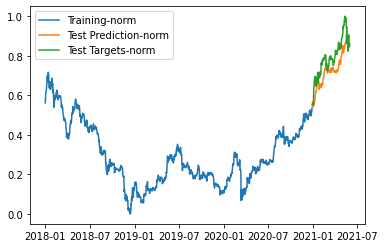

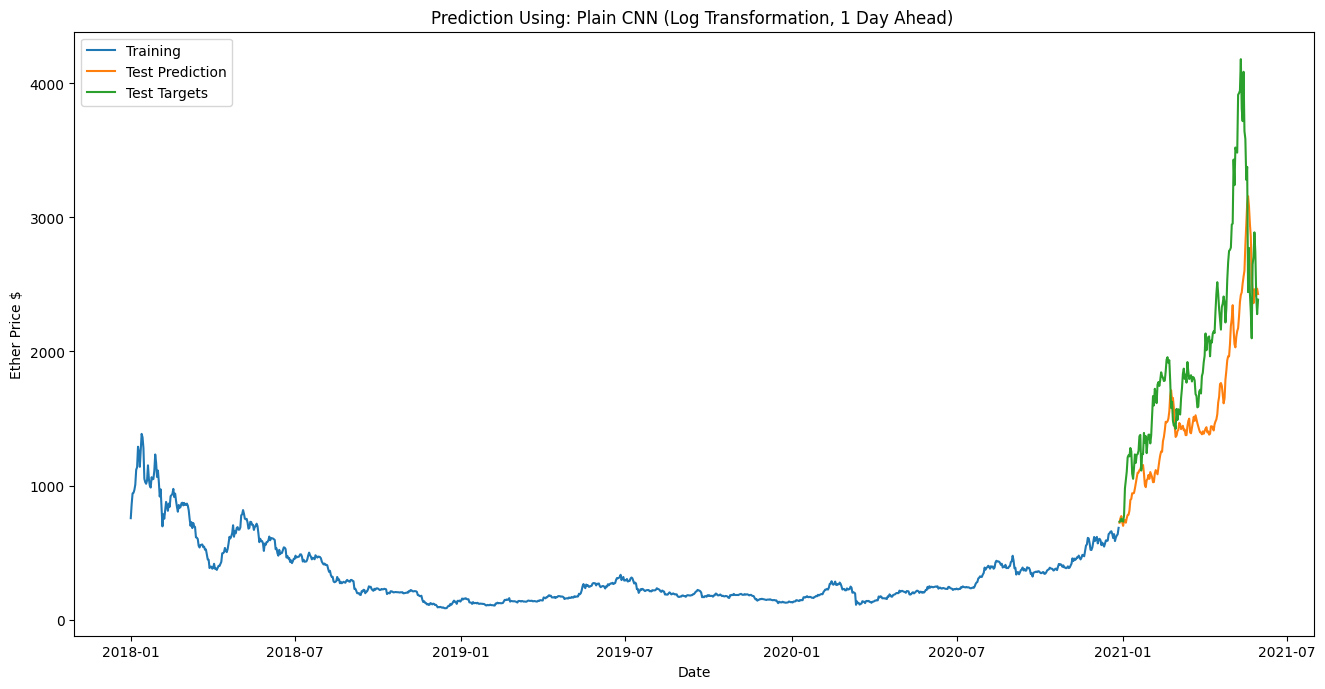

Total RMSE is:  601.9225468521892
Total APE is:  22.14756882946674
Runtime of the program is 89.41771674156189


In [16]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D


df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

n_features = train_x.shape[2]

# separate input data
#X=[train_x[:, :, i] for i in range(train_x.shape[2])]

# separate output
#Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

# Build model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_input,
n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_x, train_y, epochs=1000, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, n_input, n_features))
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='CNN')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Plain CNN (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

***
# Multi-headed CNN with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.141] 0.1, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2


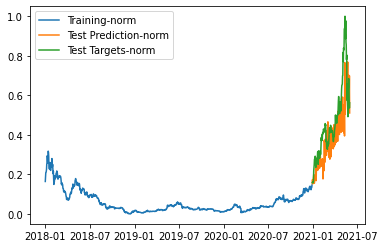

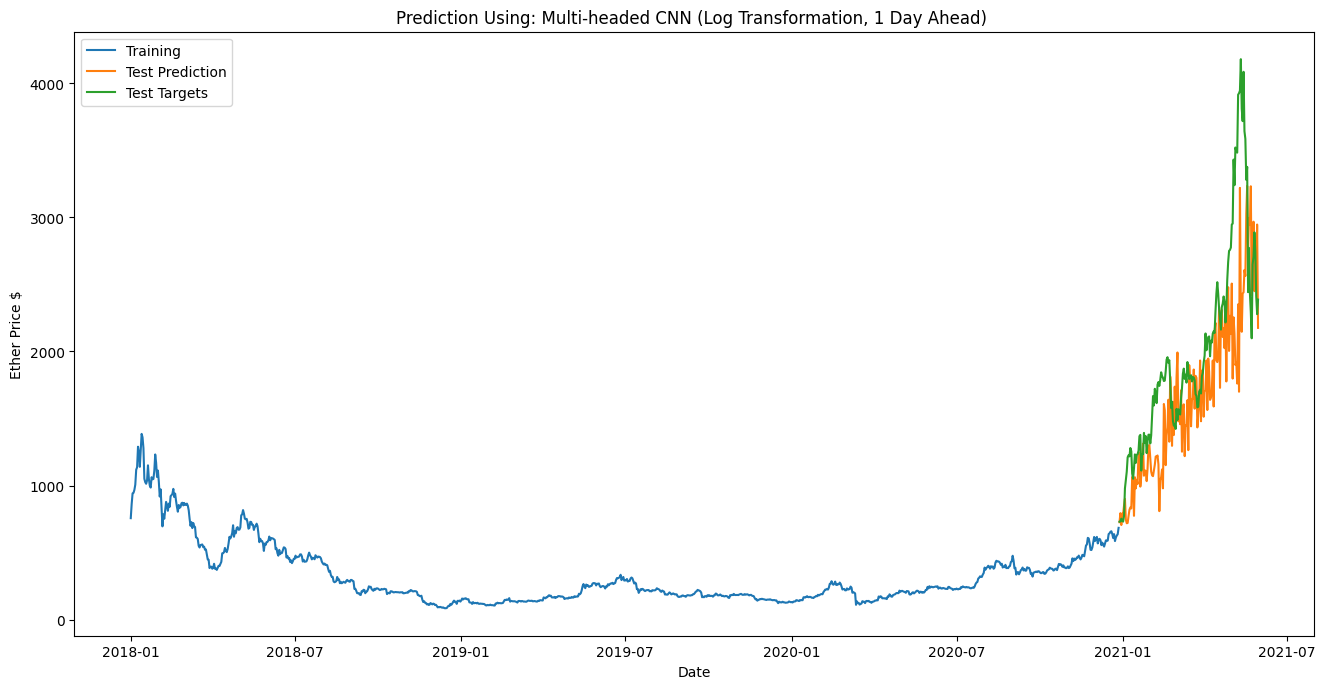

Total RMSE is:  575.8546350570056
Total APE is:  18.444969736236793
Runtime of the program is 3287.563877105713


In [4]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
#df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 7

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

# separate input data
X=[train_x[:, :, i] for i in range(train_x.shape[2])]
n_features = 1

# input model
visible= [Input(shape=(n_input,n_features)) for i in range(train_x.shape[2])]
cnn = [Conv1D(filters=64, kernel_size=2, activation='relu')(visible[i]) for i in range(train_x.shape[2])]
cnn = [MaxPooling1D(pool_size=2)(cnn[i]) for i in range(train_x.shape[2])]
cnn = [Flatten()(cnn[i]) for i in range(train_x.shape[2])]

# merge input models
merge = concatenate([cnn[i] for i in range(train_x.shape[2])])
dense = Dense(500, activation='relu')(merge)
output = Dense(n_out)(dense)
model = Model(inputs=[visible[i] for i in range(train_x.shape[2])], outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, train_y, epochs=2000, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    x=[input_x[:, i].reshape((1, n_input, n_features)) for i in range(train_x.shape[2])] 
    yhat = model.predict(x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='MLP')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])
y_testrev=(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])
y_predrev=(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-headed CNN (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

In [8]:
n_features

1

***
# Multi-output CNN with Normalization and Log Transformation 7-ahead
***

CNN Multivariate: [0.109] 0.1


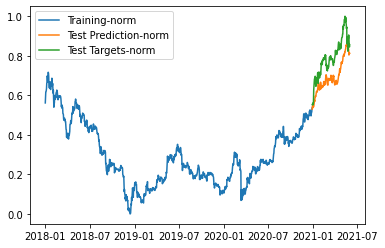

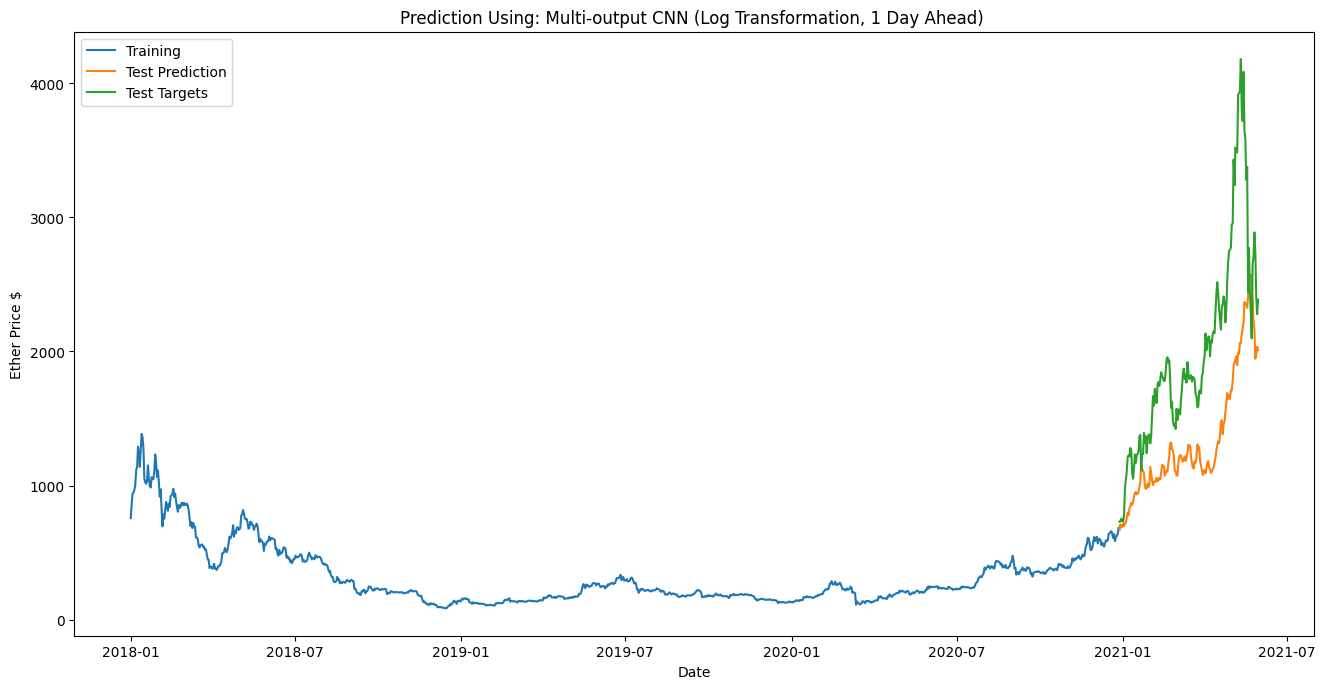

Total RMSE is:  792.482813266147
Total APE is:  31.23012071144336
Runtime of the program is 182.9534478187561


In [33]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)


scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

n_input = 14
n_out = 1

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

n_features = train_x.shape[2]

# separate output
Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

# Define model
visible = Input(shape=(n_input, n_features))
cnn = Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Flatten()(cnn)
cnn = Dense(700, activation='relu')(cnn)

# define output 
output=[Dense(1)(cnn) for i in range(n_out)]

# tie together
model = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(train_x, Y, epochs=2000, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    input_x = input_x.reshape((1, n_input, n_features))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    
    # we only want the vector forecast
    yhat = yhat[0]
    #yhat = [yhat[i][0][0] for i in range(n_out)]
    
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='CNN Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='MLP')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-output CNN (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

***
# Multi-headed Multi-output CNN with Normalization and Log Transformation 7-ahead
***

MLP Multivariate: [0.078] 0.1


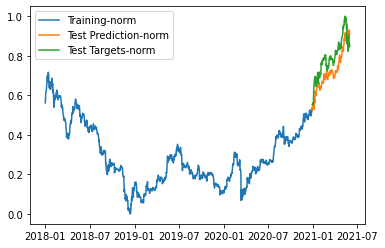

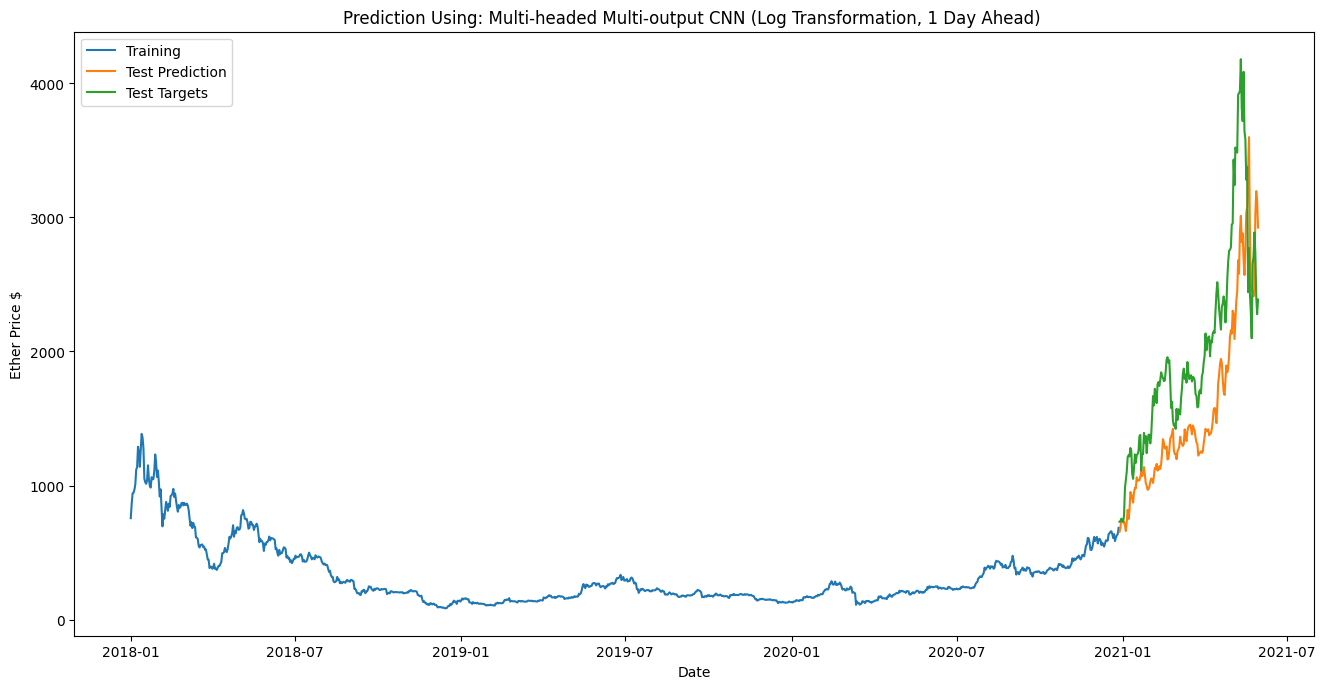

Total RMSE is:  575.9596329826055
Total APE is:  24.21750223421308
Runtime of the program is 3095.417498588562


In [39]:
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate


df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)


scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

n_input = 14
n_out = 1

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs

# flatten data
sequences = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences, n_input, n_out)

# separate input data
X=[train_x[:, :, i] for i in range(train_x.shape[2])]

# separate output
Y=[train_y[:, i].reshape((train_y.shape[0], 1)) for i in range(n_out)]

n_features = 1

# input model
visible= [Input(shape=(n_input,n_features)) for i in range(train_x.shape[2])]
cnn = [Conv1D(filters=64, kernel_size=2, activation='relu')(visible[i]) for i in range(train_x.shape[2])]
cnn = [MaxPooling1D(pool_size=2)(cnn[i]) for i in range(train_x.shape[2])]
cnn = [Flatten()(cnn[i]) for i in range(train_x.shape[2])]

# merge input models
merge = concatenate([cnn[i] for i in range(train_x.shape[2])])
dense = Dense(500, activation='relu')(merge)

# define output 
output=[Dense(1)(dense) for i in range(n_out)]

# tie together
model = Model(inputs=[visible[i] for i in range(train_x.shape[2])], outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, train_y, epochs=2000, verbose=0)

# evaluate a single model
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    x=[input_x[:, i].reshape((1, n_input, n_features)) for i in range(train_x.shape[2])] 
    # forecast the next week
    yhat = model.predict(x, verbose=0)
    
    # we only want the vector forecast
    yhat = yhat[0]
    #yhat = [yhat[i][0][0] for i in range(n_out)]
    
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

name='MLP Multivariate'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='MLP')
#plt.show()         

# Plot normalized outputs
plt.plot(train_index, y_train, label='Training-norm')
plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
plt.legend()
plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-headed Multi-output CNN (Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")